In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse as sp
import scipy.sparse.linalg as sp_linalg
from sympy.utilities.iterables import multiset_permutations

from functions import *
from lat_qub_sparce import *
from termalization_chain import *

sns.set(font_scale=1.2)

In [ ]:
path_h = 'res\\\\parameters\\\\h_{N}({upspins}),h0={h0},dh={dh},seed={seed}.npy'
path_H = 'res\\\\Hamiltonian_{N}(upspins={upspins}),t0={t0},e={e},h0={h0},dh={dh},R0={R0},seed={seed}.npz'

In [ ]:
np.random.seed(500)
t0 = 1
h0 = 0.5
dh = 0.4
#h = h0 + dh*np.random.rand(21)
#np.save(f'res\\\\parameters\\\\h_{21}({7}),h0={h0},dh={dh},seed={500}.npy', h)

In [ ]:
#N_arr = [12, 15, 18]
#upspins_arr = [4, 5, 6]
#for i in range(3):
#    h = h0 + dh*np.random.rand(N_arr[i])
#    np.save(f'res\\\\parameters\\\\h_{N_arr[i]}({upspins_arr[i]}),h0={h0},dh={dh},seed={500}.npy', h)

In [ ]:
N = 21
upspins = 7
downspins = N - upspins
e = 0.5

h = np.load(path_h.format(N=N, upspins=upspins, h0=h0, dh=dh, seed=500))

l = 1
phi = 2*np.pi/N
R = l/(2*np.sin(phi/2))
#R0 = np.round(0.1*R, 3)
R0 = 0.3
distances = [2*R*np.sin(phi/2*i) for i in range(N)]
distances_to_qubit = [(np.sqrt(R**2+R0**2-2*R*R0*np.cos(phi*i))) for i in range(N)]

prob_vector = np.array([1] * upspins + [-1] * downspins)
basis = np.array(list(multiset_permutations(prob_vector)))
dim = len(basis)

In [ ]:
spin_ring = SpinRing(N, upspins, e, l)
spin_ring.setQubit(R0)

In [ ]:
%%time

hamiltonian = Hamiltonian(spin_ring, t0, h)
H = hamiltonian.matrix

Wall time: 6h 32min 6s


In [ ]:
#sp.save_npz(f'res\\\\Hamiltonian_{N}({upspins}),t0={t0},e={e},h0={h0},dh={dh},R0={R0},seed={500}.npz', H)
H = sp.load_npz(f'res\\\\Hamiltonian_{N}({upspins}),t0={t0},e={e},h0={h0},dh={dh},R0={R0},seed={500}.npz')

In [ ]:
%%time
eigenvals, eigenvecs = sp_linalg.eigsh(H, k=dim/2, return_eigenvectors=True, which='SA')
#eigenval = np.linalg.eigvalsh(H.toarray())
idx = np.argsort(eigenvals)
eigenvals = eigenvals[idx]
eigenvecs = eigenvecs[:, idx]

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
#np.savetxt(f'res\\\\spectrum\\\\energy_spectrum_N=({N}({upspins}),R0={R0},t0={t0},h0={h0},dh={dh},seed={500}.txt', X=eigenvals)
#np.savetxt(f'res\\\\spectrum\\\\energy_eigenvectors_N={N}({upspins}),R0={R0},t0={t0},h0={h0},dh={dh},seed={500}.txt', X=eigenvecs)
eigenvals = np.loadtxt(f'res\\\\spectrum\\\\energy_spectrum_N=({N}({upspins}),R0={R0},t0={t0},h0={h0},dh={dh},seed={500}.txt')
eigenvecs = np.loadtxt(f'res\\\\spectrum\\\\energy_eigenvectors_N={N}({upspins}),R0={R0},t0={t0},h0={h0},dh={dh},seed={500}.txt', dtype=np.complex_)

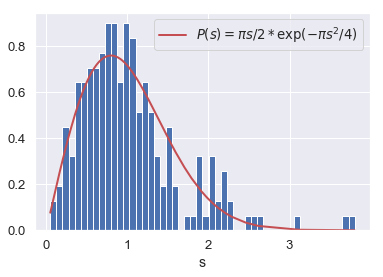

In [ ]:
spacings = energy_spacings(eigenvals)

plt.plot(spacings, np.pi/2*spacings*np.exp(-np.pi/4*spacings**2), 
         c='r', linewidth=2, label=r'$P(s)=\pi s/2*\exp(-\pi s^2/4)$')
plt.hist(spacings, bins=50, density=True)
plt.xlabel('s', fontsize=14)
plt.legend()
plt.show()

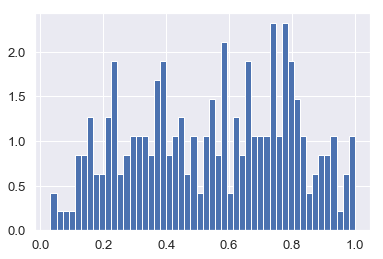

In [ ]:
r = energy_spacings_2(eigenvals)

plt.hist(r, bins=50, density=True)
plt.show()

In [ ]:
%%time
psi0 = np.random.randint(2, size=dim) # random vector from 1 and 0
psi0 = psi0/np.linalg.norm(psi0)

#threshold = int(eigenvecs.shape[1]*0.2)
#psi0 = get_psi0(eigenvecs[:,threshold:threshold+10])
#psi0 = eigenvecs[:,0]

beta = 5
psi0 = get_psi_th(psi0, beta, H)

MemoryError: 

In [ ]:
%%time
dR = 0.01
R0_pert = R0 + dR*R0
distances_to_qubit_pert = [(np.sqrt(R**2+R0_pert**2-2*R*R0_pert*np.cos(phi*i))) for i in range(N)]

#dH = hamiltonian.perturbed_matrix(h, distances_to_qubit_pert) - H
dH = H_pert(H, h, distances_to_qubit_pert)-H

Wall time: 3.22 s


In [ ]:
%%time
n_iter = 100000
t_final = 10000
t = np.linspace(0, t_final, n_iter)

eL = echoLoschmidt(t, dH, psi0, method='taylor')
eL2 = echoLoschmidt(t, dH, psi0, method='taylor_pol')

Wall time: 12.1 s


In [ ]:
eL2

array([1.        , 0.99999982, 0.99999926, ..., 0.67916864, 0.67928482,
       0.67940083])

In [ ]:
#np.save(f'res\\\\echo\\\\eL_dR={dR}_N={N}({upspins}),R0={R0},t0={t0},h0={h0},dh={dh},seed={500},t_final={t_final},n_iter={n_iter}.npy', eL)
#np.save(f'res\\\\echo\\\\eL_beta={beta}_N={N}({upspins}),R0={R0},t0={t0},h0={h0},dh={dh},seed={500},t_final={t_final},n_iter={n_iter}.npy', eL)

In [ ]:
nu = np.vdot(psi0, (dH**2).dot(psi0)) - np.vdot(psi0, dH.dot(psi0))**2
eL_quad = 1 - nu*t**2 
eL_exp = np.exp(-nu*t**2)

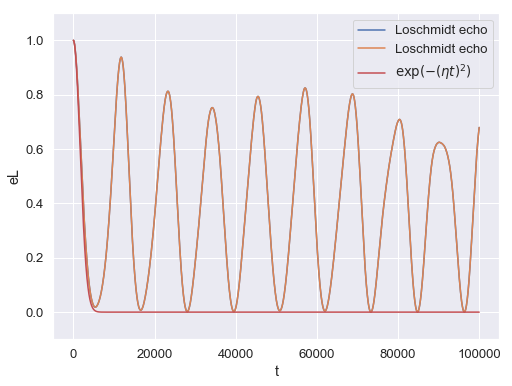

In [ ]:
fig = plt.figure(figsize=(8,6))

sc = 100000

plt.plot(t[:sc], eL2[:sc], label='Loschmidt echo')
plt.plot(t[:sc], eL[:sc], label='Loschmidt echo')
#plt.plot(t[:sc], eL_quad[:sc], label=r'$1-(\eta t)^2$', c='g')
plt.plot(t[:sc], eL_exp[:sc], label= r'$\exp(-(\eta t)^2)$', c='r')
plt.xlabel('t')
plt.ylabel('eL')
plt.legend()
plt.ylim(-0.1, 1.1)
#plt.ylim(1e-6, 2)
#plt.yscale('log')
plt.show()

In [ ]:
psi0 = np.random.randint(2, size=dim) # random vector from 1 and 0
psi0 = psi0/np.linalg.norm(psi0)

beta_arr = [1, 2, 4, 8]

for beta_i in beta_arr:
    
    psi0 = get_psi_th(psi0, beta_i, H)
    eL_i = echoLoschmidt(t, dH, psi0, method='taylor')
    
    np.save(f'res\\\\echo\\\\eL_beta={beta_i}_N={N}({upspins}),R0={R0},t0={t0},h0={h0},dh={dh},seed={500},t_final={t_final},n_iter={n_iter}.npy', eL_i)

MemoryError: 

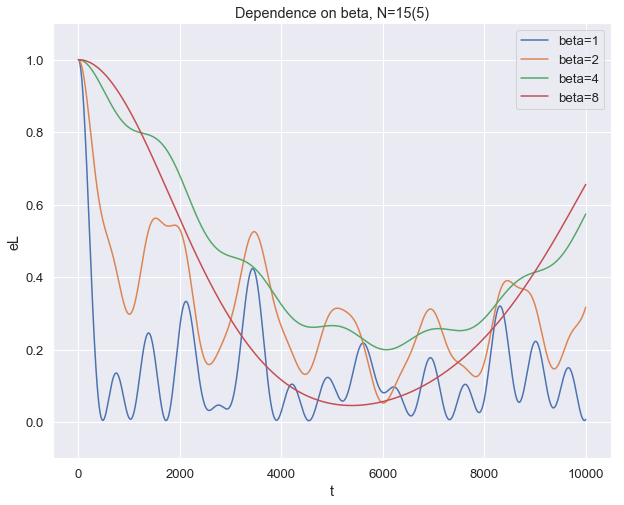

In [ ]:
sc = 100000
plt.figure(figsize=(10,8))
for beta_i in beta_arr:
    eL = np.load(f'res\\\\echo\\\\eL_beta={beta_i}_N={N}({upspins}),R0={R0},t0={t0},h0={h0},dh={dh},seed={500},t_final={t_final},n_iter={n_iter}.npy')
    plt.plot(t[:sc], eL[:sc], label=f'beta={beta_i}')

plt.ylim(-0.1, 1.1)
#plt.ylim(1e-6, 2)
#plt.yscale('log')
plt.legend()

plt.xlabel('t')
plt.ylabel('eL')
plt.title('Dependence on beta, N=15(5)')
plt.show()  

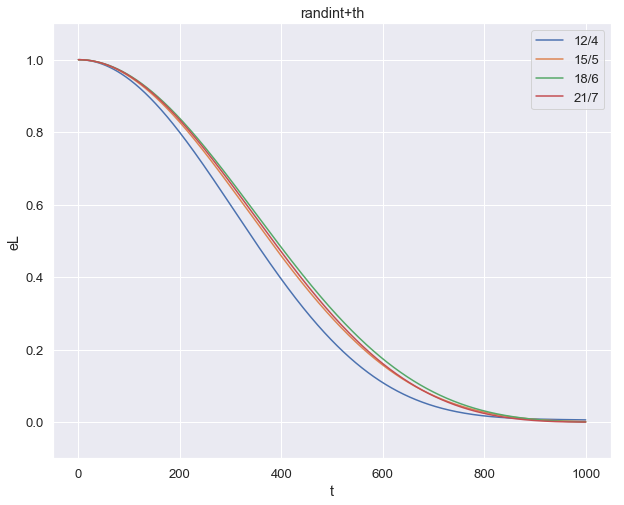

Wall time: 246 ms


In [ ]:
%%time
N_ = [12, 15, 18, 21]
upspins_ =[4, 5, 6, 7]
beta=0.1

sc = 10000
plt.figure(figsize=(10,8))
for i in range(len(N_)):
    #eL = np.loadtxt(f'res\\\\echo\\\\eL_randint={N_[i]}_up={upspins_[i]}_R0={R0}_t0={t0}_h0={h0}_dh={dh}_seed={500}_t_final={t_final}_n_iter={n_iter}.txt')
    eL = np.load(f'res\\\\echo\\\\eL_beta={beta}_N={N_[i]}({upspins_[i]}),R0={R0},t0={t0},h0={h0},dh={dh},seed={500},t_final={t_final},n_iter={n_iter}.npy')
    plt.plot(t[:sc], eL[:sc], label=f'{N_[i]}/{upspins_[i]}')

plt.ylim(-0.1, 1.1)
#plt.ylim(1e-2, 2)
#plt.yscale('log')
plt.legend()

plt.xlabel('t')
plt.ylabel('eL')
plt.title('randint+th')
plt.show()  

In [ ]:
eL = np.loadtxt(f'res\\\\echo\\\\eL_dR={dR_[i]}_N={N}_up={upspins}_R0={R0}_t0={t0}_h0={h0}_dh={dh}_seed={500}_t_final={1000}_n_iter={n_iter}.txt')
a = np.where((eL<0.5) == 1)[0][0]

0.4999851608885538

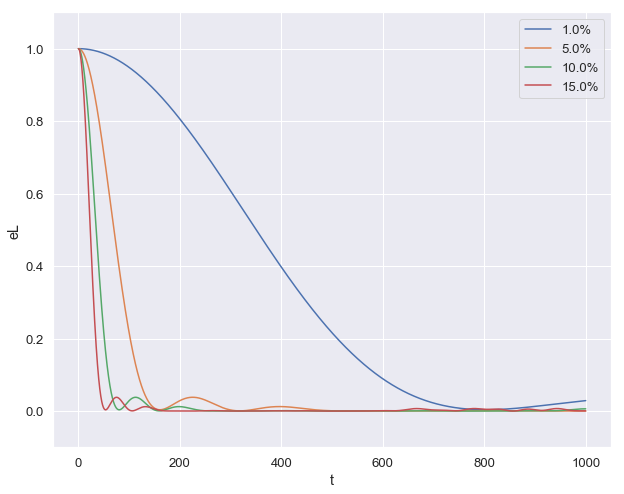

Wall time: 2.31 s


In [ ]:
%%time
dR_ = [0.01, 0.05, 0.1, 0.15]
tau_arr = []

sc = 100000
plt.figure(figsize=(10,8))
for i in range(4):
    eL = np.loadtxt(f'res\\\\echo\\\\eL_dR={dR_[i]}_N={N}_up={upspins}_R0={R0}_t0={t0}_h0={h0}_dh={dh}_seed={500}_t_final={t_final}_n_iter={n_iter}.txt')
    
    a = np.where((eL<0.5) == 1)[0][0] 
    tau = t[a]-t[0]
    tau_arr.append(tau)
    
    plt.plot(t[:sc], eL[:sc], label=f'{dR_[i]*100}%')

plt.xlabel('t')
plt.ylabel('eL')
plt.legend()
plt.ylim(-0.1, 1.1)
#plt.ylim(1e-6, 2)z
#plt.yscale('log')
plt.show()  

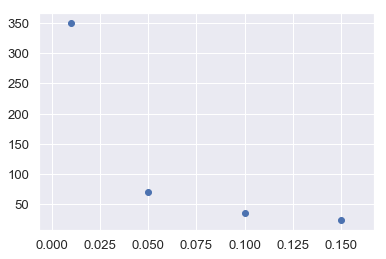

In [ ]:
plt.scatter(dR_, tau_arr)

In [ ]:
def get_psi0(eigenvec):
    
    phases = np.exp(1j*np.random.randn(eigenvec.shape[1]))
    psi0 = np.sum(eigenvec*phases, axis=1)
    
    return psi0/np.linalg.norm(psi0)
    
    
def H_pert(H, h_pert, distances_to_qubit_pert):

    # Construction of Hamiltonian
    H_pert = H.copy().tolil()

    # Diagonal elements
    for i in range(dim):
        coulomb_member_qubit = np.sum(2 * e ** 2 * basis[i]*np.log(distances_to_qubit_pert))
        field_member = np.sum(basis[i]*h_pert)
        
        H_pert[i, i] = 0
        H_pert[i, i] = coulomb_member_qubit + field_member

        for j in range(N):
            coulomb_member_j = np.sum(np.log(distances[1:N-j])*(-1) ** (basis[i, j+1:] != basis[i, j]))
            H_pert[i, i] += 2 * e ** 2 * coulomb_member_j
            
    return H_pert.tocsr()